## Plot results of multimodal classification experiments

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(
    cfg.results_dirs['multimodal'],
    # 'pilot_results',
    'pilot_results_all_feats',
    'gene'
).resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# make sure that we have data for all data types and for two replicates (random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.identifier.unique())
print(results_df.training_data.unique())
results_df.head()

(1344, 9)
[ 1 42]
['TP53' 'TET2' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['expression.me_450k' 'expression.me_27k.me_450k' 'expression.me_27k'
 'me_27k.me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.58776,0.53598,TP53,expression.me_450k,shuffled,1,train,0,gene
1,0.51092,0.45544,TP53,expression.me_450k,shuffled,1,test,0,gene
2,0.50821,0.47307,TP53,expression.me_450k,shuffled,1,cv,0,gene
3,0.52199,0.48146,TP53,expression.me_450k,shuffled,1,train,1,gene
4,0.51623,0.48159,TP53,expression.me_450k,shuffled,1,test,1,gene


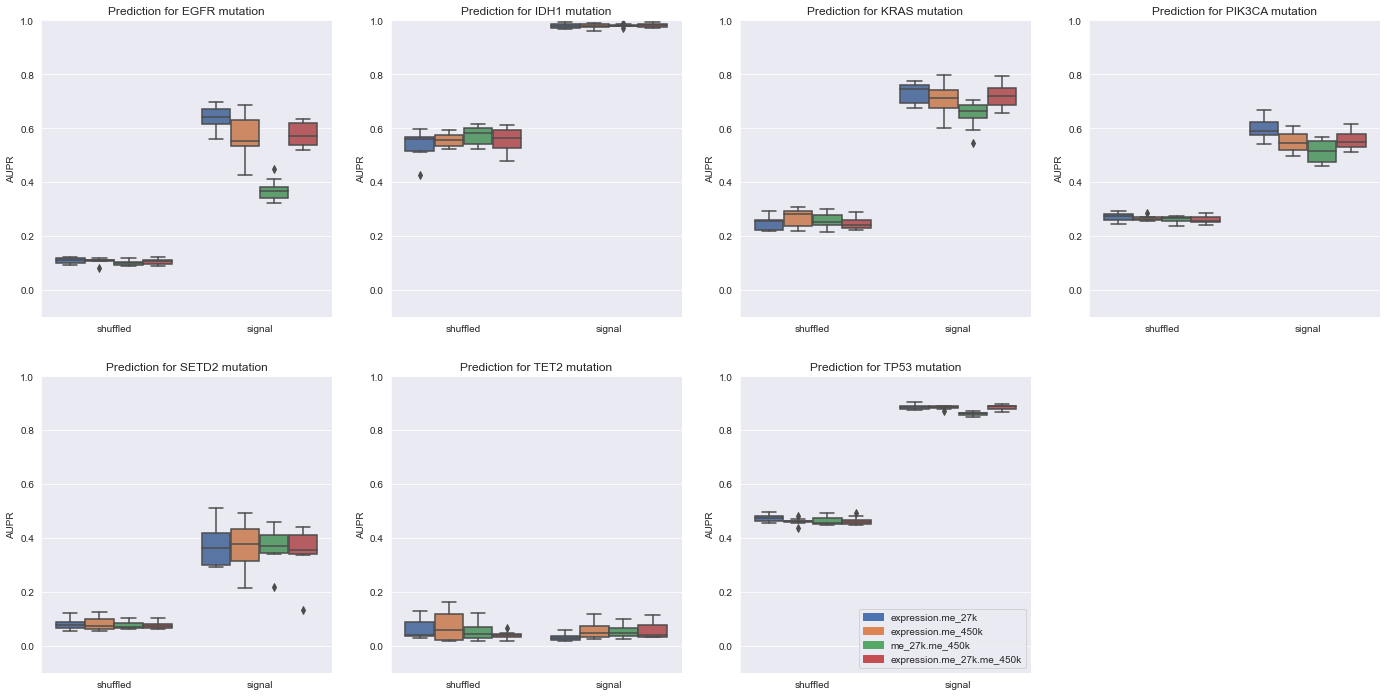

In [4]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (24, 12)})
fig, axarr = plt.subplots(2, 4)
results_df.sort_values(by=['identifier', 'signal', 'training_data'], inplace=True)
max_aupr = results_df.aupr.max()

data_order =['expression.me_27k',
             'expression.me_450k',
             'me_27k.me_450k',
             'expression.me_27k.me_450k']

# plot mean performance over all genes in Vogelstein dataset
for ix, gene in enumerate(results_df.identifier.unique()):
    
    ax = axarr[ix // 4, ix % 4]
    
    plot_df = results_df[(results_df.identifier == gene) &
                         (results_df.data_type == 'test')]

    sns.boxplot(data=plot_df, x='signal', y='aupr', hue='training_data',
                hue_order=data_order, ax=ax)
    ax.set_title('Prediction for {} mutation'.format(gene))
    ax.set_xlabel('')
    ax.set_ylabel('AUPR')
    ax.set_ylim(-0.1, max_aupr)
    ax.legend_.remove()
    
handles = []
for ix, data in enumerate(data_order):
    handle = mpatches.Patch(color=sns.color_palette()[ix], label=data)
    handles.append(handle)
    
fig.delaxes(axarr[1, 3])
plt.legend(handles=handles, loc='lower right')

In [5]:
# get results from unimodal prediction to compare with
# these are spread across 3 different results directories
# this is such a dumpster fire, I really need to clean up the results data

# expression, seed 1
unimodal_results_dir_1 = Path(
    cfg.results_dirs['mutation'],
    'bmiq_results',
    'gene'
)

# expression, seed 2
unimodal_results_dir_2 = Path(
    cfg.results_dirs['mutation'],
    'bmiq_results_2',
    'gene'
)

# me_27k, both seeds
unimodal_results_dir_3 = Path(
    cfg.results_dirs['mutation'],
    'bmiq_results_me_control',
    'gene'
)

# me_450k, both seeds
# use compressed data for this
unimodal_results_dir_4 = Path(
    cfg.results_dirs['mutation'],
    'compressed_results',
    'gene'
)

In [6]:
# load expression and me_27k results
u_results_df_1 = au.load_stratified_prediction_results(unimodal_results_dir_1, 'gene')
u_results_df_1 = u_results_df_1[(u_results_df_1.training_data == 'expression') &
                                (u_results_df_1.seed == 1)].copy()
u_results_df_2 = au.load_stratified_prediction_results(unimodal_results_dir_2, 'gene')
u_results_df_2 = u_results_df_2[u_results_df_2.training_data == 'expression'].copy()
u_results_df_3 = au.load_stratified_prediction_results(unimodal_results_dir_3, 'gene')

# load me_450k results
u_results_df_4 = au.load_compressed_prediction_results(unimodal_results_dir_4, 'gene',
                                                       old_filenames=True)
u_results_df_4 = u_results_df_4[(u_results_df_4.training_data == 'me_450k') &
                                (u_results_df_4.n_dims == 5000)].copy()
u_results_df_4.drop(columns='n_dims', inplace=True)

# make sure data loaded matches our expectations
print(u_results_df_1.training_data.unique())
print(u_results_df_2.training_data.unique())
print(u_results_df_3.training_data.unique())
print(u_results_df_4.training_data.unique())
print(u_results_df_1.seed.unique())
print(u_results_df_2.seed.unique())
print(u_results_df_3.seed.unique())
print(u_results_df_4.seed.unique())

['expression']
['expression']
['me_27k']
['me_450k']
[1]
[42]
[ 1 42]
[42  1]


In [7]:
# ok, stick with me here
# first, take the unimodal results and the multimodal results,
# and mash them together into one giant results df
all_results_df = pd.concat((results_df,
                            u_results_df_1,
                            u_results_df_2,
                            u_results_df_3,
                            u_results_df_4))

print(all_results_df.shape)
print(all_results_df.training_data.unique())
all_results_df.head()

(15240, 9)
['expression.me_27k' 'expression.me_27k.me_450k' 'expression.me_450k'
 'me_27k.me_450k' 'expression' 'me_27k' 'me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.50000,0.104120,EGFR,expression.me_27k,shuffled,42,train,0,gene
1,0.50000,0.098765,EGFR,expression.me_27k,shuffled,42,test,0,gene
2,0.50531,0.104980,EGFR,expression.me_27k,shuffled,42,cv,0,gene
3,0.56624,0.147600,EGFR,expression.me_27k,shuffled,42,train,1,gene
4,0.50897,0.123030,EGFR,expression.me_27k,shuffled,42,test,1,gene


In [8]:
# then, for each training data type, get the AUPR difference between signal and shuffled
compare_df = pd.DataFrame()
for training_data in all_results_df.training_data.unique():
    data_compare_df = au.compare_control_ind(
        all_results_df[all_results_df.training_data == training_data],
        identifier='identifier',
        metric='aupr',
        verbose=True
    )
    data_compare_df['training_data'] = training_data
    data_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
    compare_df = pd.concat((compare_df, data_compare_df))
    
compare_df.head(10)

shapes unequal for ACVR1B, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH6, skipping
shapes unequal for PAX5, skipping
shapes unequal for SMO, skipping
shapes unequal for TSHR, skipping
shapes unequal for ACVR1B, skipping
shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for CYLD, skipping
shapes unequal for HIST1H3B, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MLH1, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH6, skipping
shapes unequal for PTPN11, skipping
shapes unequal for ACVR1B, skipping
shapes unequal for CBL, skipping
shapes unequal for CYLD, skipping
shapes unequal for MLH1, skipping
shapes unequal for PAX5, skipping
shapes unequal for SMO, skipping


,gene,seed,fold,delta_aupr,training_data
0,EGFR,42,0,0.462095,expression.me_27k
1,EGFR,42,1,0.575210,expression.me_27k
2,EGFR,42,2,0.546220,expression.me_27k
3,EGFR,42,3,0.511270,expression.me_27k
4,EGFR,1,0,0.529412,expression.me_27k
5,EGFR,1,1,0.493000,expression.me_27k
6,EGFR,1,2,0.541130,expression.me_27k
7,EGFR,1,3,0.583159,expression.me_27k
8,IDH1,42,0,0.463950,expression.me_27k
9,IDH1,42,1,0.377540,expression.me_27k


In [9]:
# filter out genes that don't have comparisons for all data types
# data_type_counts = compare_df.groupby('gene').count().training_data
# valid_genes = data_type_counts[data_type_counts == len(all_results_df.training_data.unique())].index
# compare_df = compare_df[
#     compare_df.gene.isin(valid_genes)
# ]

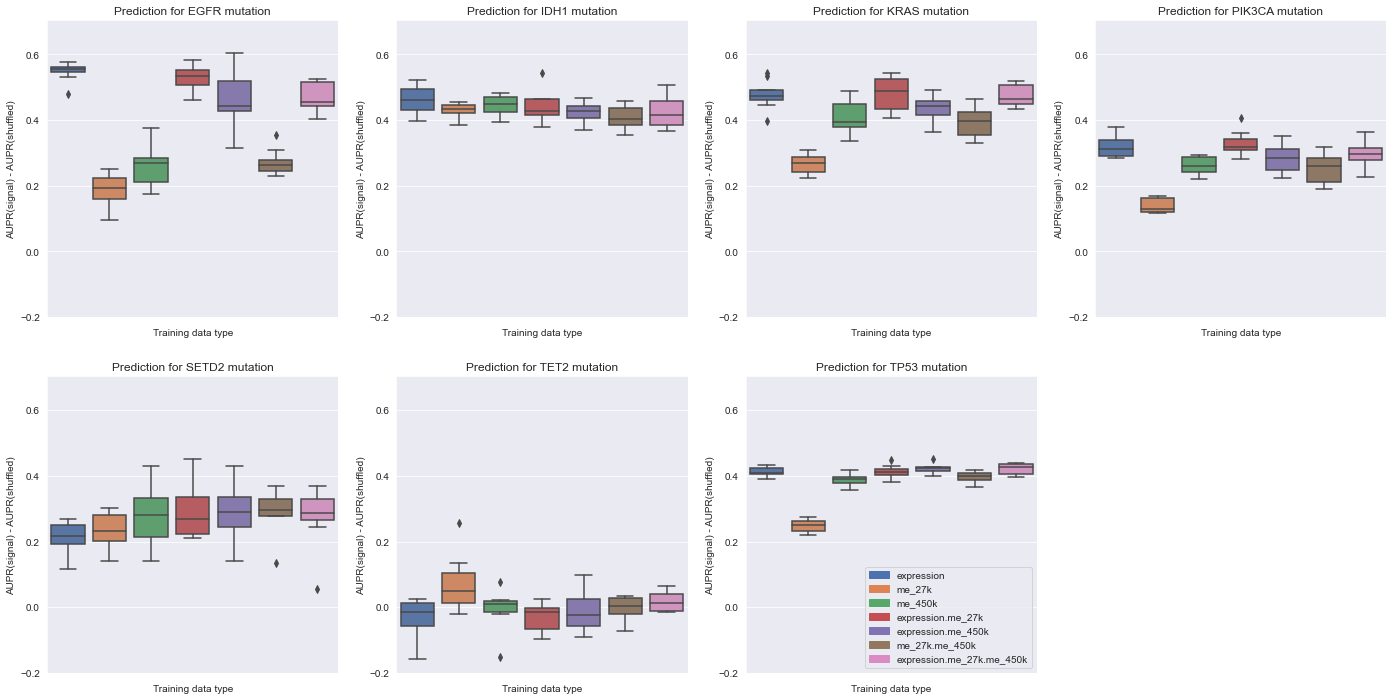

In [10]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (24, 12)})
fig, axarr = plt.subplots(2, 4)
compare_df.sort_values(by=['gene', 'training_data'], inplace=True)
compare_map = {v: str(i) for i, v in enumerate(compare_df.training_data.unique())}
compare_df['train_index'] = compare_df.training_data.map(compare_map)
min_aupr = compare_df.delta_aupr.min()
max_aupr = compare_df.delta_aupr.max()


data_order =['expression',
             'me_27k',
             'me_450k',
             'expression.me_27k',
             'expression.me_450k',
             'me_27k.me_450k',
             'expression.me_27k.me_450k']

# plot mean performance over all genes in pilot experiment
for ix, gene in enumerate(results_df.identifier.unique()):
    
    ax = axarr[ix // 4, ix % 4]
    
    plot_df = compare_df[(compare_df.gene == gene)]

    sns.boxplot(data=plot_df, x='training_data', y='delta_aupr',
                order=data_order, ax=ax)
    ax.set_title('Prediction for {} mutation'.format(gene))
    ax.set_xlabel('Training data type')
    # hide x-axis tick text
    ax.get_xaxis().set_ticklabels([])
    ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
    ax.set_ylim(-0.2, max_aupr)
    
handles = []
for ix, data in enumerate(data_order):
    handle = mpatches.Patch(color=sns.color_palette()[ix], label=data)
    handles.append(handle)
    
fig.delaxes(axarr[1, 3])
plt.legend(handles=handles, loc='lower right')